# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py and create directories

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py
        
if not os.path.exists('figs'):
    !mkdir figs

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf
from utils import decorate, savefig

In [4]:
ks = np.arange(1, 11)
prior_k = Pmf(1, ks)
prior_k.normalize()
prior_k.index.name = 'k'

In [5]:
ts = np.linspace(0, 1, 21)
prior_t = Pmf(1, ts)
prior_t.normalize()
prior_t.index.name = 't'

In [6]:
from scipy.stats import norm

lambdas = np.linspace(0.01, 20, 50)
qs = np.log(lambdas)

mu, sigma = 0.3, 0.7
ps = norm.pdf(qs, mu, sigma)

prior_lambda = Pmf(ps, lambdas)
prior_lambda.normalize()
prior_lambda.index.name = 'lambda'

prior_lambda.mean()

2.7952013319456332

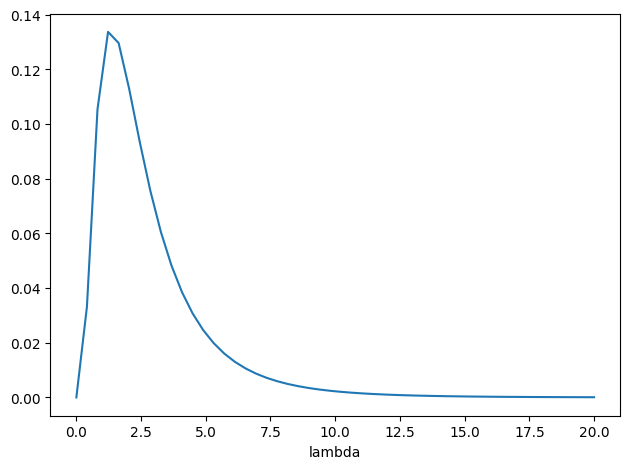

In [7]:
prior_lambda.plot()
decorate()

In [8]:
PK, PLAMBDA, PT = np.meshgrid(prior_k, prior_lambda, prior_t)
prior = PK * PLAMBDA * PT
prior.shape

(50, 10, 21)

In [9]:
from scipy.stats import poisson

def update(prior, data):
    n = data
    
    # TODO: special case n==0

    K, LAMBDA, T = np.meshgrid(ks, lambdas, ts)
    
    like = poisson(mu=LAMBDA*T).pmf(K-n)
    if n == 0:
        like += poisson(mu=LAMBDA*T).sf(K-n)

    posterior = prior * like
    posterior /= posterior.sum()
    
    return posterior

In [13]:
n = 3
posterior = update(prior, n)

In [14]:
marginal_k = Pmf(posterior.sum(axis=(0, 2)), ks)
marginal_lambda = Pmf(posterior.sum(axis=(1, 2)), lambdas)

marginal_k.mean(), marginal_lambda.mean()

(4.25472830442544, 2.693603624832523)

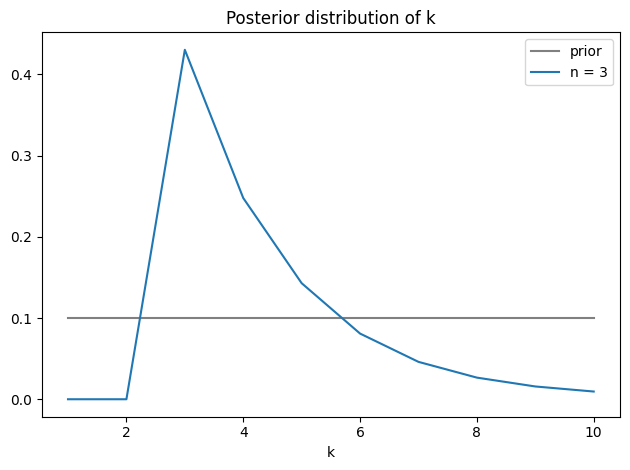

In [15]:
prior_k.plot(label=f'prior', color='gray')
marginal_k.plot(label=f'n = {n}')
decorate(title='Posterior distribution of k')

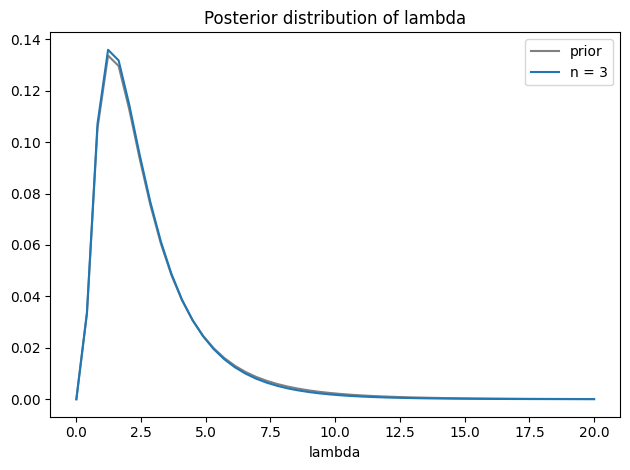

In [16]:
prior_lambda.plot(label='prior', color='gray')
marginal_lambda.plot(label=f'n = {n}')
decorate(title='Posterior distribution of lambda')

In [51]:
def make_poisson(lam, k):
    qs = np.arange(k+1)
    ps = poisson.pmf(qs, lam)
    pmf = Pmf(ps, qs)
    pmf[k] += poisson.sf(k, lam)
    return pmf

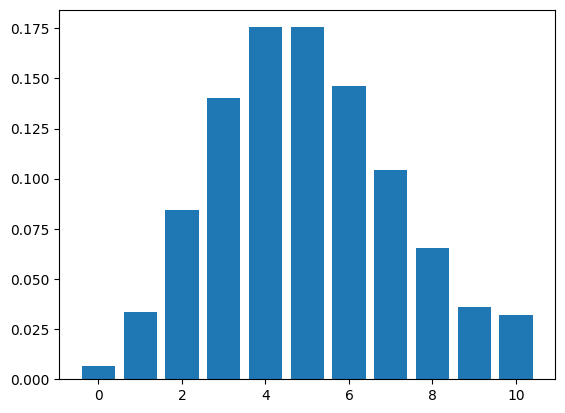

In [52]:
pmf = make_poisson(5, 10)
pmf.bar()

In [53]:
def compute_sales(posterior):
    marginal_joint = posterior.sum(axis=2)
    marginal_joint.shape

    K, LAMBDA = np.meshgrid(ks, lambdas)
    K.shape

    SALES = marginal_joint * np.minimum(K, LAMBDA)
    return np.sum(SALES)

In [54]:
compute_sales(posterior)

2.048177523297997

In [59]:
def compute_sales(posterior):
    marginal_joint = pd.DataFrame(posterior.sum(axis=2), index=lambdas, columns=ks)

    res = []
    for (lam, k), p in marginal_joint.stack().items():
        exp_sales = make_poisson(lam, k).mean()
        res.append((exp_sales, p))
        
    qs, ps = np.transpose(res)
    pmf = Pmf(ps, qs)
    return pmf.mean()

In [60]:
compute_sales(posterior)

2.0372943847605636

In [61]:
res = []

for n in range(11):
    posterior = update(prior, n)
    marginal_k = Pmf(posterior.sum(axis=(0, 2)), ks)
    marginal_lambda = Pmf(posterior.sum(axis=(1, 2)), lambdas)

    k, lam = marginal_k.mean(), marginal_lambda.mean()
    sales = compute_sales(posterior)
    res.append((n, k, lam, sales))

In [65]:
df = pd.DataFrame(res, columns=['n', 'mean k', 'mean lambda', 'exp sales'])
df

,n,mean k,mean lambda,exp sales
0,0,2.409571,4.361937,2.025360
1,1,2.322331,2.740616,1.643844
2,2,3.294089,2.720710,2.036440
3,3,4.254728,2.693604,2.269578
4,4,5.199590,2.656726,2.393205
5,5,6.122093,2.606749,2.441859
6,6,7.013147,2.539618,2.435680
7,7,7.860703,2.450961,2.384995
8,8,8.649959,2.337343,2.295145
9,9,9.365430,2.199540,2.172083


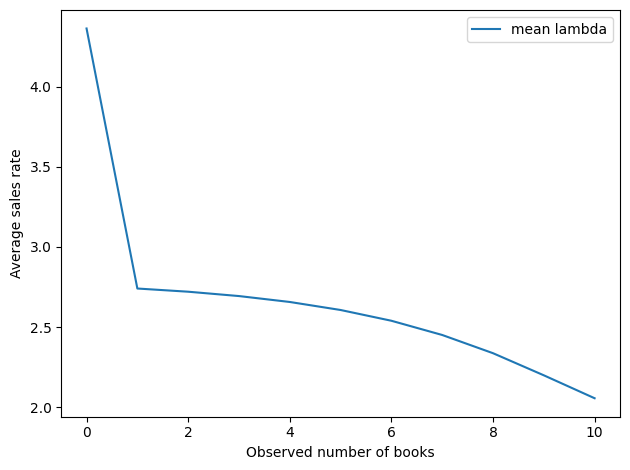

In [67]:
df['mean lambda'].plot()
decorate(xlabel='Observed number of books',
         ylabel='Average sales rate')

5

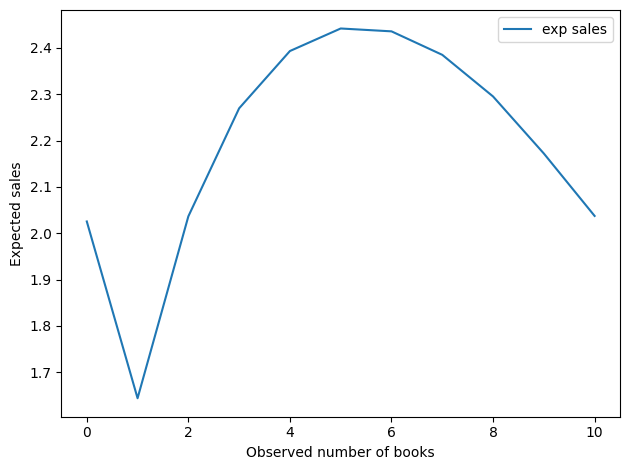

In [70]:
df['exp sales'].plot()
decorate(xlabel='Observed number of books',
         ylabel='Expected sales')
df['exp sales'].argmax()

In [63]:
import xarray as xr
import numpy as np

# Create a 2D DataArray using a dictionary for dimensions and coordinates
data = np.random.rand(3, 4)
coordinates = {'latitude': [10, 20, 30], 'longitude': [100, 110, 120, 130]}

# Create the 2D DataArray
data_array_2d = xr.DataArray(data, coords=coordinates.items(), dims=coordinates.keys())

# Display the 2D DataArray
print(data_array_2d)


<xarray.DataArray (latitude: 3, longitude: 4)>
array([[0.67563753, 0.20865251, 0.11984538, 0.11573044],
       [0.06685941, 0.34505141, 0.83588825, 0.90362598],
       [0.12914904, 0.9271302 , 0.80307685, 0.67546577]])
Coordinates:
  * latitude   (latitude) int64 10 20 30
  * longitude  (longitude) int64 100 110 120 130
